# Custom model run on extreme years:

This notebook allows running XGBoost++ or other models on custom data:

## Setting up:

In [ ]:
from matplotlib import pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import re
from pathlib import Path
import xarray as xr
import warnings
import re
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV as RSCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, MaxNLocator

warnings.filterwarnings("ignore")

In [1]:
from scripts.xgb_helpers import *
from scripts.stakes_processing import *
from scripts.xgb_input import *
from scripts.xgb_model import *
from scripts.xgb_model_varcomb import *
from scripts.plots_clean import *
from scripts.xgb_metrics import *
from scripts.xgb_extreme import *
from scripts.PDD_model_modules import *
from scripts.PDD_model_calibration import *
from scripts.PDD_helpers import *

%load_ext autoreload
%autoreload 2

In [2]:
# set seed everywhere:
seed_all(SEED)

# Parameter grid of XGBoost training Hyperparameters
param_grid = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'n_estimators': np.arange(50, 300, 15),
    'max_depth': np.arange(3, 10, 1),
}
INPUT_TYPE = "MeteoSuisse"

KFOLD = True
if KFOLD:
    NUM_FOLDS = 5
    FOLD = 'kfold'
else:
    NUM_FOLDS = 1
    FOLD = 'single_fold'

path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

In [3]:
# Colors:

# For bars and lines:
color_diff_xgb = '#878787'
color_diff_xgbplus = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 2)
color_xgbplus = colors[0]
color_tim = colors[1]
color_xgb = '#4575b4'

# Violin and boxplots:
colors_temp_freq = sns.color_palette(get_cmap_hex(cm.devon, 8))
boxplot_style = {
    "width": .2,
    "showcaps": False,
    "palette": colors_temp_freq,
    "flierprops": {
        "marker": "x"
    },
}

marker_tim = 's'
marker_xgb = 'o'

## Pre-processing:

In [4]:
# Get number of stakes per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of stakes
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes:', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)

# glacier names:
glaciers = list(glStakes.keys())

# Select stakes that have at least 20 years of measurements
glStakes_20years, glStakes_20years_sorted, glStakes_20years_all = getStakesNyears(
    glaciers,
    glStakes,
    path_glacattr,
    path_era5_stakes,
    input_type=INPUT_TYPE,
    N=20)
print('After preprocessing:\n----\nNumber of glaciers:',
      len(glStakes_20years.keys()))
num_stakes = 0
for gl in glStakes_20years.keys():
    num_stakes += len(glStakes_20years[gl])
print('Number of stakes:', num_stakes)

Total number of stakes: 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]
1991 2023
1991 2023
1991 2023
2011 2023
2004 2023
2004 2023
2004 2023
2004 2023
2005 2023
2009 2023
2009 2023
1961 2023
1961 2023
2006 2023
2006 2023
2006 2023
1955 2023
Missing years: [2016, 2017, 2018, 2019, 2020]
1920 2023
1995 2023
1920 2023
1920 2023
1920 2023
1920 2023
1948 1984
1948 1984
1948 1984
2006 2021
2006 2021
2009 2023
1914 2023
1914 2023
1955 2023
1914 2023
1914 2023
1914 2023
1955 2023
2001 2023
2001 2023
2012 2023
2012 2023
1996 2023
1948 1984
1948 1984
1966 2023
1966 2023
1966 2023
After preprocessing:
----
Number of glaciers: 13
Number of stakes: 28


In [6]:
# Rename stakes so that ordered by elevation from P1 to P(X highest):
glaciers = list(glStakes_20years.keys())
s_end, gl_mb, = {}, {}
start_years, end_years = [], []
stakes_per_el = {}
var = "b_a_fix"
for g in range(len(glaciers)):
    gl = glaciers[g]  # One glacier
    height = {}
    for stake in glStakes_20years[gl]:
        # Get coordinates and time of file for this stake:
        fileName = re.split(".csv", stake)[0][:-3]
        df_stake = read_stake_csv(path_glacattr, stake,
                                  COI).sort_values(by="date_fix0")

        # remove category 0
        df_stake = df_stake[df_stake.vaw_id > 0]

        # remove 2021:
        df_stake = df_stake[df_stake.date_fix0.dt.year < 2021]

        # years:
        years = [
            df_stake.date_fix0.iloc[i].year
            for i in range(len(df_stake.date_fix0))
        ]

        start_years.append(years[0])
        end_years.append(years[-1])

        s_end[fileName] = years  # start and end years
        gl_mb[fileName] = df_stake[var].values / (
            1000)  # MB of stake (change to m w.e.)
        height[fileName] = df_stake.height.iloc[0]  # Height of stake

    # Sort stakes per elevation
    print(height)
    stakes_per_el[gl] = list(
        pd.Series(height).sort_values(ascending=True).index.values)

rename_stakes, glStakes_20years_renamed = {}, {}
for gl in stakes_per_el.keys():
    for i, stake in enumerate(stakes_per_el[gl]):
        rename_stakes[stake] = f"{GLACIER_CORRECT[gl]}-P{i+1}"
        updateDic(glStakes_20years_renamed, gl,
                  f"{GLACIER_CORRECT[gl]}-P{i+1}")

rename_stakes, glStakes_20years_renamed

{'basodino_P5': 2886.7744920000005, 'basodino_P8': 3116.2885880000003, 'basodino_P10': 2759.6606536000004}
{'gries_P32': 2654.0219294000003, 'gries_P112': 3101.4990409200004}
{'schwarzberg_P2': 2815.49513372}
{'aletsch_P5': 3526.320971, 'aletsch_P0': 2089.50294328, 'aletsch_P9': 2989.76978664, 'aletsch_P10': 2906.3757971200007, 'aletsch_P3': 3380.745516}
{'limmern_P2': 2641.7760650000005, 'limmern_P1': 2514.5717416, 'limmern_P3': 2848.991556}
{'clariden_U': 2945.80231296, 'clariden_L': 2743.35311232}
{'allalin_P1': 2897.44286848}
{'silvretta_P9': 2586.799167, 'silvretta_BO': 3054.78944116, 'silvretta_BU': 2812.58672904}
{'hohlaub_P2': 3078.1231082000004}
{'pers_P24': 2891.33369724}
{'corbassiere_B2': 2711.9036606400005}
{'plattalva_P10': 2859.3380456000004, 'plattalva_P11': 2850.831543}
{'gietro_P1': 3373.93588476, 'gietro_P3': 2858.10703112, 'gietro_P5': 3128.1982310800004}


({'basodino_P10': 'Basodino-P1',
  'basodino_P5': 'Basodino-P2',
  'basodino_P8': 'Basodino-P3',
  'gries_P32': 'Gries-P1',
  'gries_P112': 'Gries-P2',
  'schwarzberg_P2': 'Schwarzberg-P1',
  'aletsch_P0': 'Aletsch-P1',
  'aletsch_P10': 'Aletsch-P2',
  'aletsch_P9': 'Aletsch-P3',
  'aletsch_P3': 'Aletsch-P4',
  'aletsch_P5': 'Aletsch-P5',
  'limmern_P1': 'Limmern-P1',
  'limmern_P2': 'Limmern-P2',
  'limmern_P3': 'Limmern-P3',
  'clariden_L': 'Clariden-P1',
  'clariden_U': 'Clariden-P2',
  'allalin_P1': 'Allalin-P1',
  'silvretta_P9': 'Silvretta-P1',
  'silvretta_BU': 'Silvretta-P2',
  'silvretta_BO': 'Silvretta-P3',
  'hohlaub_P2': 'Hohlaub-P1',
  'pers_P24': 'Pers-P1',
  'corbassiere_B2': 'Corbassiere-P1',
  'plattalva_P11': 'Plattalva-P1',
  'plattalva_P10': 'Plattalva-P2',
  'gietro_P3': 'Gietro-P1',
  'gietro_P5': 'Gietro-P2',
  'gietro_P1': 'Gietro-P3'},
 {'basodino': ['Basodino-P1', 'Basodino-P2', 'Basodino-P3'],
  'gries': ['Gries-P1', 'Gries-P2'],
  'schwarzberg': ['Schwarzber

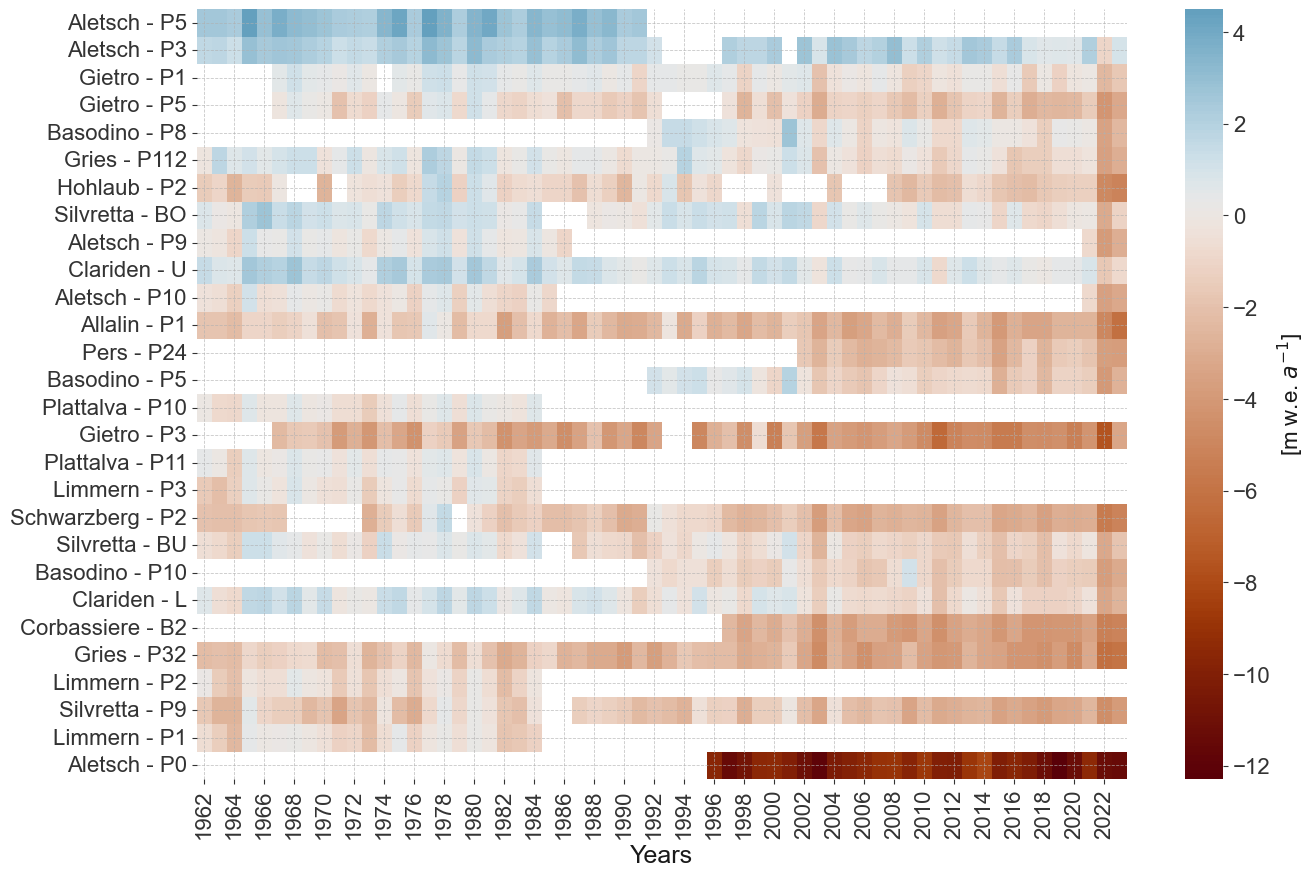

In [7]:
totalDF_mb, el_stakes = createHeatMatrixStakes(path_glacattr,
                                               glStakes_20years,
                                               COI,
                                               var="b_a_fix")

DF60s = totalDF_mb[(totalDF_mb.index > 1961)]
totalDF_mb_tr = DF60s.transpose().reset_index()
stakes = totalDF_mb_tr['index']
gl_correct = [
    GLACIER_CORRECT[stake.split('_')[0]] + ' - {}'.format(stake.split('_')[1])
    for stake in stakes
]
totalDF_mb_tr['stakeNames'] = gl_correct
totalDF_mb_tr = totalDF_mb_tr.drop(['index'], axis=1).set_index('stakeNames')

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data=totalDF_mb_tr,
            center=0,
            cmap=cm.vik_r,
            cbar_kws={'label': '[m w.e. $a^{-1}$]'},
            ax=ax)
ax.set_ylabel('')
ax.set_xlabel("Years", fontsize=18)
plt.savefig("figures/fig1_stakesHeatmap.pdf",
            format="pdf",
            bbox_inches="tight")

In [8]:
stakesExtreme = [
    'aletsch_P3', 'gietro_P1', 'gietro_P5', 'basodino_P8', 'gries_P112',
    'hohlaub_P2', 'silvretta_BO', 'clariden_U', 'allalin_P1', 'pers_P24',
    'basodino_P5', 'gietro_P3', 'schwarzberg_P2', 'silvretta_BU',
    'basodino_P10', 'clariden_L', 'corbassiere_B2', 'gries_P32',
    'silvretta_P9', 'aletsch_P0'
]

glStakesExtreme = {}
for stake in stakesExtreme:
    glacier = stake.split('_')[0]
    updateDic(glStakesExtreme, glacier, f'{stake}_mb.csv')
glStakesExtreme, len(stakesExtreme)

({'aletsch': ['aletsch_P3_mb.csv', 'aletsch_P0_mb.csv'],
  'gietro': ['gietro_P1_mb.csv', 'gietro_P5_mb.csv', 'gietro_P3_mb.csv'],
  'basodino': ['basodino_P8_mb.csv',
   'basodino_P5_mb.csv',
   'basodino_P10_mb.csv'],
  'gries': ['gries_P112_mb.csv', 'gries_P32_mb.csv'],
  'hohlaub': ['hohlaub_P2_mb.csv'],
  'silvretta': ['silvretta_BO_mb.csv',
   'silvretta_BU_mb.csv',
   'silvretta_P9_mb.csv'],
  'clariden': ['clariden_U_mb.csv', 'clariden_L_mb.csv'],
  'allalin': ['allalin_P1_mb.csv'],
  'pers': ['pers_P24_mb.csv'],
  'schwarzberg': ['schwarzberg_P2_mb.csv'],
  'corbassiere': ['corbassiere_B2_mb.csv']},
 20)

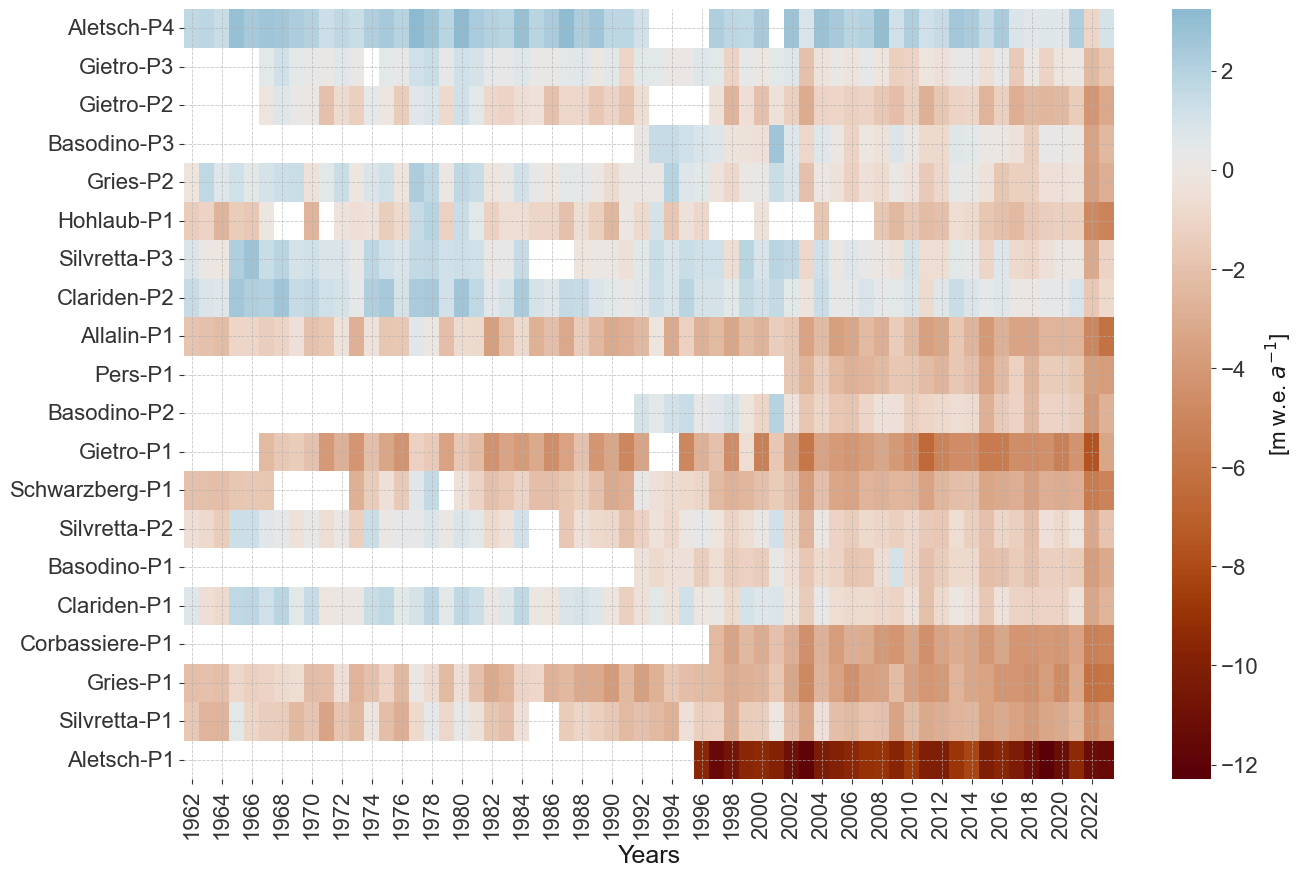

In [9]:
totalDF_mb, el_stakes = createHeatMatrixStakes(path_glacattr,
                                               glStakesExtreme,
                                               COI,
                                               var="b_a_fix")

DF60s = totalDF_mb[(totalDF_mb.index > 1961)]
totalDF_mb_tr = DF60s.transpose().reset_index()
stakes = totalDF_mb_tr['index']
# gl_correct = [
#     GLACIER_CORRECT[stake.split('_')[0]] + ' - {}'.format(stake.split('_')[1])
#     for stake in stakes
# ]
# totalDF_mb_tr['stakeNames'] = gl_correct
totalDF_mb_tr['stakeNames'] = [rename_stakes[stake] for stake in stakes]
totalDF_mb_tr = totalDF_mb_tr.drop(['index'], axis=1).set_index('stakeNames')

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data=totalDF_mb_tr,
            center=0,
            cmap=cm.vik_r,
            cbar_kws={'label': '[m w.e. $a^{-1}$]'},
            ax=ax)
ax.set_ylabel('')
ax.set_xlabel("Years", fontsize=18)
plt.savefig("figures/fig1_stakesHeatmap.pdf",
            format="pdf",
            bbox_inches="tight")

## Run XGB:

In [10]:
best_combi = [(['t2m_May', 't2m_June', 't2m_July', 't2m_Aug', 't2m_Sep'], [
    'tp_Oct',
    'tp_Nov',
    'tp_Dec',
    'tp_Jan',
    'tp_Feb',
])]


if KFold:
    fold = "kfold"
else:
    fold = "single_fold"

path_extreme = path_save_xgboost_stakes + f"{fold}/{INPUT_TYPE}/extreme_years/"

print(f"Creating path: {path_extreme}")
# Empty folder and create path if non existance
createPath(path_extreme)
# emptyfolder(path_extreme)

glaciers = list(glStakes_20years.keys())

Creating path: ../../data/MB_modeling/XGBoost/ind_stakes/kfold/MeteoSuisse/extreme_years/


Processing aletsch - clariden_U


/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["years"] = target_years
/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["years"] = target_years
/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

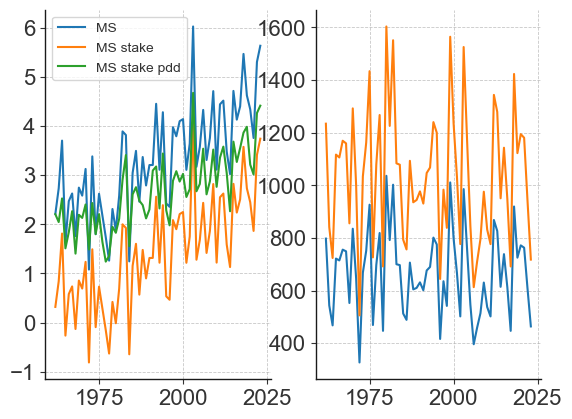

In [11]:
# Example of different inputs:
stake = 'clariden_U_mb.csv'
stakeName = stake.split('_')[0] + '_' + stake.split('_')[1]
print(f"Processing {glacier} - {stakeName}")

weights_t2m = np.ones(len(best_combi[0][0]))
weights_tp = np.ones(len(best_combi[0][1]))

# Create input and target for model:
vars_ = ['t2m', 'tp']
inputDF, target, xr_full = createSingleInput(best_combi,
                                             weights_t2m,
                                             weights_tp,
                                             stakeName,
                                             INPUT_TYPE,
                                             vars_,
                                             log=False)

vars_ = ['t2m_corr', 'tp_corr']
inputDF_corr, target_corr, xr_full = createSingleInput(best_combi,
                                                       weights_t2m,
                                                       weights_tp,
                                                       stakeName,
                                                       INPUT_TYPE,
                                                       vars_,
                                                       log=False)

vars_ = ['pdd', 'tp_corr']
inputDF_pdd, target_pdd, xr_full = createSingleInput(best_combi,
                                                     weights_t2m,
                                                     weights_tp,
                                                     stakeName,
                                                     INPUT_TYPE,
                                                     vars_,
                                                     log=False)

ax = plt.subplot(1, 2, 1)
ax.plot(inputDF['t2m_mean'], label='MS')
ax.plot(inputDF_corr['t2m_mean'], label='MS stake')
ax.plot(inputDF_pdd['t2m_mean'], label='MS stake pdd')
ax.legend()

ax = plt.subplot(1, 2, 2)
ax.plot(inputDF['tp_tot'], label='MS')
ax.plot(inputDF_corr['tp_tot'], label='MS stake')

### Tested on 2022 and 2023:

In [12]:
# emptyfolder(path_extreme)

In [13]:
%%time
# test on 2022 and 2023:
RUN = False
# possible_var = [['t2m', 'tp'], ['t2m_corr', 'tp_corr'], ['pdd', 'tp_corr']]
possible_var = [['t2m', 'tp']]

weights_t2m = np.ones(len(best_combi[0][0]))
weights_tp = np.ones(len(best_combi[0][1]))

if RUN:
    for varcombi in possible_var:
        print('Running for variables:', varcombi)
        test_index = [2022, 2023]
        pred_stake, metrics_stake, target_stake = [], [], []
        std_obs_stake = []
        for glacier in tqdm(glStakesExtreme.keys(), desc='glaciers'):
            for stake in glStakesExtreme[glacier]:
                stakeName = stake.split('_')[0] + '_' + stake.split('_')[1]
                # print(f"Processing {glacier} - {stakeName}")
                # Create input and target for model:
                inputDF, target, xr_full = createSingleInput(best_combi,
                                                             weights_t2m,
                                                             weights_tp,
                                                             stakeName,
                                                             INPUT_TYPE,
                                                             log=False,
                                                             vars_=varcombi)

                # Separate into training and testing:
                X, y, time = createSingleInputArraysExtreme(test_index,
                                                            target,
                                                            inputDF,
                                                            log=False)

                # apply XGBoost model:
                predictions_XG, val_loss, train_loss, epochs, best_iteration, params_RF = applySingleXGBoost(
                    X, y, param_grid, log=False)
                rmse, mae, pearson, rsquared2 = evalMetrics(
                    y["test"], predictions_XG)
                pred_stake.append(predictions_XG)
                metrics_stake.append([rmse, mae, np.std(y['train2'])])
                target_stake.append(y["test"])

        # Assemble for all stakes:
        dfMetrics_xgb = pd.DataFrame(metrics_stake,
                                     columns=['RMSE', 'MAE', 'std_obs'])
        dfMetrics_xgb = dfMetrics_xgb[['RMSE', 'MAE', 'std_obs']] / (1000)

        dfMetrics_xgb['stake'] = np.concatenate([[
            stake.split('_')[0] + '_' + stake.split('_')[1]
            for stake in glStakesExtreme[gl]
        ] for gl in glStakesExtreme.keys()])
        dfMetrics_xgb['stake'] = dfMetrics_xgb['stake'].apply(
            lambda x: rename_stakes[x])
        dfMetrics_xgb['glacier'] = np.concatenate(
            [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])

        dfPred_xgb = pd.DataFrame(pred_stake, columns=test_index)
        dfPred_xgb[['2022_target', '2023_target']] = target_stake
        dfPred_xgb['stake'] = np.concatenate([[
            stake.split('_')[0] + '_' + stake.split('_')[1]
            for stake in glStakesExtreme[gl]
        ] for gl in glStakesExtreme.keys()])
        dfPred_xgb['stake'] = dfPred_xgb['stake'].apply(
            lambda x: rename_stakes[x])
        dfPred_xgb['glacier'] = np.concatenate(
            [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])

        # Metrics on 2022 and 2023 alone:
        dfMetrics_xgb['RMSE_2022'] = dfPred_xgb.apply(
            lambda x: mean_squared_error([x[2022]], [x['2022_target']],
                                         squared=False),
            axis=1) / (1000)
        dfMetrics_xgb['RMSE_2023'] = dfPred_xgb.apply(
            lambda x: mean_squared_error([x[2023]], [x['2023_target']],
                                         squared=False),
            axis=1) / (1000)
        dfMetrics_xgb['MAE_2022'] = dfPred_xgb.apply(
            lambda x: mean_absolute_error([x[2022]], [x['2022_target']]),
            axis=1) / (1000)
        dfMetrics_xgb['MAE_2023'] = dfPred_xgb.apply(
            lambda x: mean_absolute_error([x[2023]], [x['2023_target']]),
            axis=1) / (1000)

        # Save to csv:
        name_metrics = f'metrics_2022_2023_{varcombi[0]}_{varcombi[1]}.csv'
        print(f'Save {name_metrics} to {path_extreme}')
        dfMetrics_xgb.to_csv(path_extreme + name_metrics)
        name_pred = f'predictions_2022_2023_{varcombi[0]}_{varcombi[1]}.csv'
        print(f'Save {name_pred} to {path_extreme}')
        dfPred_xgb.to_csv(path_extreme + name_pred)

# Tested on 2022 and 2023:
dfMetrics_xgb_2022_2023 = pd.read_csv(path_extreme +
                                      'metrics_2022_2023_t2m_tp.csv')
dfPred_xgb_2022_2023 = pd.read_csv(path_extreme +
                                   'predictions_2022_2023_t2m_tp.csv')
dfPred_xgb_2022_2023.rename(columns={'2023': 2023, '2022': 2022}, inplace=True)
dfPred_xgb_2022_2023.head()

CPU times: user 7.6 ms, sys: 24 µs, total: 7.63 ms
Wall time: 30.9 ms


,Unnamed: 0,2022,2023,2022_target,2023_target,stake,glacier
0,0,1511.37440,948.6321,-958,985,Aletsch-P4,aletsch
1,1,-10858.88400,-10858.8840,-11311,-11443,Aletsch-P1,aletsch
2,2,-1004.38745,-1147.4863,-2490,-1689,Gietro-P3,gietro
3,3,-2704.79420,-2875.5540,-4224,-3195,Gietro-P2,gietro
4,4,-4762.75800,-4751.6025,-7613,-3320,Gietro-P1,gietro


### Tested on 2023:

In [14]:
# test on 2023 only:
RUN = False
# possible_var = [['t2m', 'tp'], ['t2m_corr', 'tp_corr'], ['pdd', 'tp_corr']]
possible_var = [['t2m', 'tp']]

if RUN:
    for varcombi in possible_var:
        print('Running for variables:', varcombi)
        test_index = [2023]
        pred_stake, metrics_stake, target_stake = [], [], []
        params_stake = []
        for glacier in tqdm(glStakesExtreme.keys(), desc='glaciers'):
            for stake in glStakesExtreme[glacier]:
                stakeName = stake.split('_')[0] + '_' + stake.split('_')[1]
                stakeName = 'silvretta_BU'
                # Create input and target for model:
                inputDF, target, xr_full = createSingleInput(best_combi,
                                                             weights_t2m,
                                                             weights_tp,
                                                             stakeName,
                                                             INPUT_TYPE,
                                                             log=False,
                                                             vars_=varcombi)
                print(inputDF.shape)
                print(inputDF)

                # Separate into training and testing:
                X, y, time = createSingleInputArraysExtreme(test_index,
                                                            target,
                                                            inputDF,
                                                            log=False)

                # apply XGBoost model:
                predictions_XG, val_loss, train_loss, epochs, best_iteration, params_RF = applySingleXGBoost(
                    X, y, param_grid, log=False)
                rmse, mae, pearson, rsquared2 = evalMetrics(
                    y["test"], predictions_XG)
                pred_stake.append(predictions_XG)
                metrics_stake.append([rmse, mae, np.std(y['train2'])])
                target_stake.append(y["test"])
                
                # parameters:
                params_stake.append([params_RF['learning_rate'], params_RF['n_estimators'], params_RF['max_depth']])

        # Assemble for all stakes:
        dfMetrics_xgb = pd.DataFrame(metrics_stake,
                                     columns=['RMSE', 'MAE', 'std_obs'])
        dfMetrics_xgb = dfMetrics_xgb[['RMSE', 'MAE', 'std_obs']] / (1000)

        dfMetrics_xgb['stake'] = np.concatenate([[
            stake.split('_')[0] + '_' + stake.split('_')[1]
            for stake in glStakesExtreme[gl]
        ] for gl in glStakesExtreme.keys()])
        dfMetrics_xgb['stake'] = dfMetrics_xgb['stake'].apply(
            lambda x: rename_stakes[x])
        dfMetrics_xgb['glacier'] = np.concatenate(
            [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])
        
        dfParams_xgb = pd.DataFrame(params_stake, columns=['learning_rate', 'n_estimators', 'max_depth'])
        dfParams_xgb['stake'] = np.concatenate([[
            stake.split('_')[0] + '_' + stake.split('_')[1]
            for stake in glStakesExtreme[gl]
        ] for gl in glStakesExtreme.keys()])
        dfParams_xgb['stake'] = dfParams_xgb['stake'].apply(
            lambda x: rename_stakes[x])
        dfParams_xgb['glacier'] = np.concatenate(
            [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])
        
        dfPred_xgb = pd.DataFrame(pred_stake, columns=test_index)
        dfPred_xgb[['2023_target']] = target_stake
        dfPred_xgb['stake'] = np.concatenate([[
            stake.split('_')[0] + '_' + stake.split('_')[1]
            for stake in glStakesExtreme[gl]
        ] for gl in glStakesExtreme.keys()])
        dfPred_xgb['stake'] = dfPred_xgb['stake'].apply(
            lambda x: rename_stakes[x])
        dfPred_xgb['glacier'] = np.concatenate(
            [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])

        # Metrics on 2022 and 2023 alone:
        dfMetrics_xgb['RMSE_2023'] = dfPred_xgb.apply(
            lambda x: mean_squared_error([x[2023]], [x['2023_target']],
                                         squared=False),
            axis=1) / (1000)
        dfMetrics_xgb['MAE_2023'] = dfPred_xgb.apply(
            lambda x: mean_absolute_error([x[2023]], [x['2023_target']]),
            axis=1) / (1000)

        # Save to csv:
        name_metrics = f'metrics_2023_{varcombi[0]}_{varcombi[1]}.csv'
        print(f'Save {name_metrics} to {path_extreme}')
        dfMetrics_xgb.to_csv(path_extreme + name_metrics)
        name_pred = f'predictions_2023_{varcombi[0]}_{varcombi[1]}.csv'
        print(f'Save {name_pred} to {path_extreme}')
        dfPred_xgb.to_csv(path_extreme + name_pred)
        name_params = f'params_2023_{varcombi[0]}_{varcombi[1]}.csv'
        print(f'Save {name_params} to {path_extreme}')
        dfParams_xgb.to_csv(path_extreme + name_params)

# Tested on 2023 only:
dfMetrics_xgb_2023 = pd.read_csv(path_extreme + 'metrics_2023_t2m_tp.csv')
dfPred_xgb_2023 = pd.read_csv(path_extreme + 'predictions_2023_t2m_tp.csv')
dfPred_xgb_2023.rename(columns={'2023': 2023}, inplace=True)
dfPred_xgb_2023.head()

,Unnamed: 0,2023,2023_target,stake,glacier
0,0,18.618004,985,Aletsch-P4,aletsch
1,1,-10918.729000,-11443,Aletsch-P1,aletsch
2,2,-2269.164600,-1689,Gietro-P3,gietro
3,3,-3352.891600,-3195,Gietro-P2,gietro
4,4,-6853.703000,-3320,Gietro-P1,gietro


In [15]:
dfMetrics_xgb_2023.head(2)

,Unnamed: 0,RMSE,MAE,std_obs,stake,glacier,RMSE_2023,MAE_2023
0,0,0.966382,0.966382,0.763721,Aletsch-P4,aletsch,0.966382,0.966382
1,1,0.524271,0.524271,0.988240,Aletsch-P1,aletsch,0.524271,0.524271


### Tested on 2022:

In [16]:
# test on 2022 only:
RUN = False
possible_var = [['t2m', 'tp']]

weights_t2m = np.ones(len(best_combi[0][0]))
weights_tp = np.ones(len(best_combi[0][1]))

if RUN:
    for varcombi in possible_var:
        print('Running for variables:', varcombi)
        test_index = [2022]
        pred_stake, metrics_stake, target_stake = [], [], []
        for glacier in tqdm(glStakesExtreme.keys(), desc='glaciers'):
            for stake in glStakesExtreme[glacier]:
                stakeName = stake.split('_')[0] + '_' + stake.split('_')[1]
                # print(f"Processing {glacier} - {stakeName}")
                # Create input and target for model:
                inputDF, target, xr_full = createSingleInput(best_combi,
                                                             weights_t2m,
                                                             weights_tp,
                                                             stakeName,
                                                             INPUT_TYPE,
                                                             log=False,
                                                             vars_=varcombi)

                # Separate into training and testing:
                X, y, time = createSingleInputArraysExtreme(test_index,
                                                            target,
                                                            inputDF,
                                                            log=False)

                # apply XGBoost model:
                predictions_XG, val_loss, train_loss, epochs, best_iteration, params_RF = applySingleXGBoost(
                    X, y, param_grid, log=False)
                rmse, mae, pearson, rsquared2 = evalMetrics(
                    y["test"], predictions_XG)
                pred_stake.append(predictions_XG)
                metrics_stake.append([rmse, mae, np.std(y['train2'])])
                target_stake.append(y["test"])

        # Assemble for all stakes:
        dfMetrics_xgb = pd.DataFrame(metrics_stake,
                                     columns=['RMSE', 'MAE', 'std_obs'])
        dfMetrics_xgb = dfMetrics_xgb[['RMSE', 'MAE', 'std_obs']] / (1000)

        dfMetrics_xgb['stake'] = np.concatenate([[
            stake.split('_')[0] + '_' + stake.split('_')[1]
            for stake in glStakesExtreme[gl]
        ] for gl in glStakesExtreme.keys()])
        dfMetrics_xgb['stake'] = dfMetrics_xgb['stake'].apply(
            lambda x: rename_stakes[x])
        dfMetrics_xgb['glacier'] = np.concatenate(
            [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])

        dfPred_xgb = pd.DataFrame(pred_stake, columns=test_index)
        dfPred_xgb[['2022_target']] = target_stake
        dfPred_xgb['stake'] = np.concatenate([[
            stake.split('_')[0] + '_' + stake.split('_')[1]
            for stake in glStakesExtreme[gl]
        ] for gl in glStakesExtreme.keys()])
        dfPred_xgb['stake'] = dfPred_xgb['stake'].apply(
            lambda x: rename_stakes[x])
        dfPred_xgb['glacier'] = np.concatenate(
            [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])

        # Metrics on 2022 and 2022 alone:
        dfMetrics_xgb['RMSE_2022'] = dfPred_xgb.apply(
            lambda x: mean_squared_error([x[2022]], [x['2022_target']],
                                         squared=False),
            axis=1) / (1000)
        dfMetrics_xgb['MAE_2022'] = dfPred_xgb.apply(
            lambda x: mean_absolute_error([x[2022]], [x['2022_target']]),
            axis=1) / (1000)

        # Save to csv:
        name_metrics = f'metrics_2022_{varcombi[0]}_{varcombi[1]}.csv'
        print(f'Save {name_metrics} to {path_extreme}')
        dfMetrics_xgb.to_csv(path_extreme + name_metrics)
        name_pred = f'predictions_2022_{varcombi[0]}_{varcombi[1]}.csv'
        print(f'Save {name_pred} to {path_extreme}')
        dfPred_xgb.to_csv(path_extreme + name_pred)

# Tested on 2022 only:
dfMetrics_xgb_2022 = pd.read_csv(path_extreme + 'metrics_2022_t2m_tp.csv')
dfPred_xgb_2022 = pd.read_csv(path_extreme + 'predictions_2022_t2m_tp.csv')
dfPred_xgb_2022.rename(columns={'2022': 2022}, inplace=True)
dfPred_xgb_2022.head()

,Unnamed: 0,2022,2022_target,stake,glacier
0,0,1470.6528,-958,Aletsch-P4,aletsch
1,1,-10776.2020,-11311,Aletsch-P1,aletsch
2,2,-1886.4261,-2490,Gietro-P3,gietro
3,3,-2992.1830,-4224,Gietro-P2,gietro
4,4,-4545.5680,-7613,Gietro-P1,gietro


## Run PDD:

In [17]:
glaciers = list(glStakesExtreme.keys())
RUN = False
if RUN:
    # Get surface height of stakes and era5/MS grid:
    stake_grid_alt, stake_alt = getSurfaceHeight(glaciers,
                                                 glStakesExtreme,
                                                 input_type=INPUT_TYPE)

    # Get temperature gradients:
    print('Constructing temperature gradients from ERA5:')
    dTdz_stakes = getTemperatureGradients(glaciers, glStakesExtreme)

# Initial values
SUR_0, SNOW_0, BAL_0 = 0, 0, 0  # start as ice
dPdz = 1 / 10000  # % increase/100m constant for now changed to unit/m

c_prec = 1.5  # []
DDFsnow, DDFice = 3 / 1000, 6 / 1000  # constant [m d-1 K-1]

inital_params = {
    'sur0': SUR_0,
    'sno0': SNOW_0,
    'bal0': BAL_0,
}

# CALIBRATION:
# Range of parameters to fit during round 1 (cprec) and round 2 (DDFsnow)
DDFsnow_range = np.linspace(1 / (1000), 10 / (1000), 25)
c_prec_range = np.linspace(0.8, 4, 25)

weights_t2m_pdd = np.ones(len(best_combi[0][0]))
weights_tp_pdd = np.ones(len(best_combi[0][1]))

### Tested on 2022 and 2023:

In [18]:
RUN = False
if RUN:
    test_years = [2022, 2023]
    vars_ = ['t2m', 'tp']

    pred_stake_ann, pred_stake_win, metrics_stake_pdd, target_pdd,  = [], [], [], []
    c_stake, DDF_stake = {}, {}
    for glacier in tqdm(glStakesExtreme.keys(), desc='glaciers'):
        for stake in glStakesExtreme[glacier]:
            stakeName = stake.split('_')[0] + '_' + stake.split('_')[1]
            # print(f"Processing {glacier} - {stakeName}")

            # Get target and input:
            el_stake = stake_alt[stakeName]
            el_grid = stake_grid_alt[stakeName]
            constants = {
                "dPdz": dPdz,
                "el_stake": round(el_stake, 3),
                "el_grid": round(el_grid, 3),
            }

            # Create input and target for model:
            inputDF, target, xr_full = createSingleInput(best_combi,
                                                         weights_t2m_pdd,
                                                         weights_tp_pdd,
                                                         stakeName,
                                                         INPUT_TYPE,
                                                         log=False,
                                                         vars_=vars_)

            # Separate into training and testing
            ann_mb, w_mb, time_pdd = createSingleInputArraysExtreme_PDD(
                target, test_years, seed=SEED)

            pred_pdd_w, pred_pdd_ann, c_year, DDFsnow_year = applySinglePDD(
                stake,
                xr_full,
                time_pdd,
                ann_mb,
                w_mb,
                dTdz_stakes,
                dPdz,
                c_prec,
                DDFsnow,
                DDFice,
                DDFsnow_range,
                c_prec_range,
                inital_params,
                constants,
                input_type=INPUT_TYPE)

            # Save PDD parameters:
            c_stake[stakeName] = c_year
            DDF_stake[stakeName] = DDFsnow_year

            rmse_pdd, mae_pdd, pearson_pdd, rsquared2_pdd = evalMetrics(
                ann_mb["test"], pred_pdd_ann)

            # Save:
            pred_stake_ann.append(pred_pdd_ann)
            pred_stake_win.append(pred_pdd_w)
            metrics_stake_pdd.append(
                [rmse_pdd, mae_pdd, pearson_pdd, rsquared2_pdd])
            target_pdd.append(ann_mb["test"])

    # Assemble for all stakes:
    dfMetrics_pdd = pd.DataFrame(metrics_stake_pdd,
                                 columns=['RMSE', 'MAE', 'Pearson', 'R2'])
    dfMetrics_pdd = dfMetrics_pdd[['RMSE', 'MAE']] / (1000)
    dfMetrics_pdd['stake'] = np.concatenate([[
        stake.split('_')[0] + '_' + stake.split('_')[1]
        for stake in glStakesExtreme[gl]
    ] for gl in glStakesExtreme.keys()])
    dfMetrics_pdd['stake'] = dfMetrics_pdd['stake'].apply(
        lambda x: rename_stakes[x])
    dfMetrics_pdd['glacier'] = np.concatenate(
        [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])

    dfPred_pdd = pd.DataFrame(pred_stake_ann, columns=test_years)
    dfPred_pdd[['2022_target', '2023_target']] = target_pdd
    dfPred_pdd['stake'] = np.concatenate([[
        stake.split('_')[0] + '_' + stake.split('_')[1]
        for stake in glStakesExtreme[gl]
    ] for gl in glStakesExtreme.keys()])
    dfPred_pdd['stake'] = dfPred_pdd['stake'].apply(lambda x: rename_stakes[x])
    dfPred_pdd['glacier'] = np.concatenate([[gl] * len(glStakesExtreme[gl])
                                            for gl in glStakesExtreme.keys()])

    # Metrics on 2022 and 2023 alone:
    dfMetrics_pdd['RMSE_2022'] = dfPred_pdd.apply(lambda x: mean_squared_error(
        [x[2022]], [x['2022_target']], squared=False),
                                                  axis=1) / (1000)
    dfMetrics_pdd['RMSE_2023'] = dfPred_pdd.apply(lambda x: mean_squared_error(
        [x[2023]], [x['2023_target']], squared=False),
                                                  axis=1) / (1000)
    dfMetrics_pdd['MAE_2022'] = dfPred_pdd.apply(
        lambda x: mean_absolute_error([x[2022]], [x['2022_target']]),
        axis=1) / (1000)
    dfMetrics_pdd['MAE_2023'] = dfPred_pdd.apply(
        lambda x: mean_absolute_error([x[2023]], [x['2023_target']]),
        axis=1) / (1000)

    # Parameter range:
    with open(path_extreme + f"c_2022_2023.pkl", "wb") as fp:
        pickle.dump(c_stake, fp)
    with open(path_extreme + f"DDF_2022_2023.pkl", "wb") as fp:
        pickle.dump(DDF_stake, fp)

    # save to csv:
    dfMetrics_pdd.to_csv(path_extreme + 'metrics_pdd_2022_2023.csv')
    dfPred_pdd.to_csv(path_extreme + 'predictions_pdd_2022_2023.csv')

# Tested on 2022 and 2023:
dfMetrics_pdd_2022_2023 = pd.read_csv(path_extreme +
                                      'metrics_pdd_2022_2023.csv')
dfPred_pdd_2022_2023 = pd.read_csv(path_extreme +
                                   'predictions_pdd_2022_2023.csv')
dfPred_pdd_2022_2023.rename(columns={'2023': 2023, '2022': 2022}, inplace=True)

### Tested on 2022:

In [19]:
# 2022 only:
RUN = False
if RUN:
    vars_ = ['t2m', 'tp']
    test_years = [2022]
    pred_stake_ann, pred_stake_win, metrics_stake_pdd, target_pdd = [], [], [], []
    for glacier in tqdm(glStakesExtreme.keys(), desc='glaciers'):
        for stake in glStakesExtreme[glacier]:
            stakeName = stake.split('_')[0] + '_' + stake.split('_')[1]
            # print(f"Processing {glacier} - {stakeName}")

            # Get target and input:
            el_stake = stake_alt[stakeName]
            el_grid = stake_grid_alt[stakeName]
            constants = {
                "dPdz": dPdz,
                "el_stake": round(el_stake, 3),
                "el_grid": round(el_grid, 3),
            }

            # Create input and target for model:
            inputDF, target, xr_full = createSingleInput(best_combi,
                                                         weights_t2m_pdd,
                                                         weights_tp_pdd,
                                                         stakeName,
                                                         INPUT_TYPE,
                                                         log=False,
                                                         vars_=vars_)

            # Separate into training and testing
            ann_mb, w_mb, time_pdd = createSingleInputArraysExtreme_PDD(
                target, test_years, seed=SEED)

            pred_pdd_w, pred_pdd_ann, c_year, DDFsnow_year = applySinglePDD(
                stake,
                xr_full,
                time_pdd,
                ann_mb,
                w_mb,
                dTdz_stakes,
                dPdz,
                c_prec,
                DDFsnow,
                DDFice,
                DDFsnow_range,
                c_prec_range,
                inital_params,
                constants,
                input_type=INPUT_TYPE)

            rmse_pdd, mae_pdd, pearson_pdd, rsquared2_pdd = evalMetrics(
                ann_mb["test"], pred_pdd_ann)

            # Save:
            pred_stake_ann.append(pred_pdd_ann)
            pred_stake_win.append(pred_pdd_w)
            metrics_stake_pdd.append(
                [rmse_pdd, mae_pdd, pearson_pdd, rsquared2_pdd])
            target_pdd.append(ann_mb["test"])

    # Assemble for all stakes:
    dfMetrics_pdd = pd.DataFrame(metrics_stake_pdd,
                                 columns=['RMSE', 'MAE', 'Pearson', 'R2'])
    dfMetrics_pdd = dfMetrics_pdd[['RMSE', 'MAE']] / (1000)
    dfMetrics_pdd['stake'] = np.concatenate([[
        stake.split('_')[0] + '_' + stake.split('_')[1]
        for stake in glStakesExtreme[gl]
    ] for gl in glStakesExtreme.keys()])
    dfMetrics_pdd['stake'] = dfMetrics_pdd['stake'].apply(
        lambda x: rename_stakes[x])
    dfMetrics_pdd['glacier'] = np.concatenate(
        [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])
    dfPred_pdd = pd.DataFrame(pred_stake_ann, columns=test_years)
    dfPred_pdd[['2022_target']] = target_pdd
    dfPred_pdd['stake'] = np.concatenate([[
        stake.split('_')[0] + '_' + stake.split('_')[1]
        for stake in glStakesExtreme[gl]
    ] for gl in glStakesExtreme.keys()])
    dfPred_pdd['stake'] = dfPred_pdd['stake'].apply(lambda x: rename_stakes[x])
    dfPred_pdd['glacier'] = np.concatenate([[gl] * len(glStakesExtreme[gl])
                                            for gl in glStakesExtreme.keys()])

    # Metrics on 2022 alone:
    dfMetrics_pdd['RMSE_2022'] = dfPred_pdd.apply(lambda x: mean_squared_error(
        [x[2022]], [x['2022_target']], squared=False),
                                                  axis=1) / (1000)
    dfMetrics_pdd['MAE_2022'] = dfPred_pdd.apply(
        lambda x: mean_absolute_error([x[2022]], [x['2022_target']]),
        axis=1) / (1000)

    # save to csv:
    dfMetrics_pdd.to_csv(path_extreme + 'metrics_pdd_2022.csv')
    dfPred_pdd.to_csv(path_extreme + 'predictions_pdd_2022.csv')

# Tested on 2022 and 2022:
dfMetrics_pdd_2022 = pd.read_csv(path_extreme + 'metrics_pdd_2022.csv')
dfPred_pdd_2022 = pd.read_csv(path_extreme + 'predictions_pdd_2022.csv')
dfPred_pdd_2022.rename(columns={'2022': 2022}, inplace=True)
dfMetrics_pdd_2022.head(2)

,Unnamed: 0,RMSE,MAE,stake,glacier,RMSE_2022,MAE_2022
0,0,1.246336,1.246336,Aletsch-P4,aletsch,1.246336,1.246336
1,1,1.962296,1.962296,Aletsch-P1,aletsch,1.962296,1.962296


### Tested on 2023:

In [20]:
# 2023 only:
RUN = False
if RUN:
    vars_ = ['t2m', 'tp']
    test_years = [2023]
    pred_stake_ann, pred_stake_win, metrics_stake_pdd, target_pdd = [], [], [], []
    for glacier in tqdm(glStakesExtreme.keys(), desc='glaciers'):
        for stake in glStakesExtreme[glacier]:
            stakeName = stake.split('_')[0] + '_' + stake.split('_')[1]
            # print(f"Processing {glacier} - {stakeName}")

            # Get target and input:
            el_stake = stake_alt[stakeName]
            el_grid = stake_grid_alt[stakeName]
            constants = {
                "dPdz": dPdz,
                "el_stake": round(el_stake, 3),
                "el_grid": round(el_grid, 3),
            }

            # Create input and target for model:
            inputDF, target, xr_full = createSingleInput(best_combi,
                                                         weights_t2m_pdd,
                                                         weights_tp_pdd,
                                                         stakeName,
                                                         INPUT_TYPE,
                                                         log=False,
                                                         vars_=vars_)

            # Separate into training and testing
            ann_mb, w_mb, time_pdd = createSingleInputArraysExtreme_PDD(
                target, test_years, seed=SEED)

            pred_pdd_w, pred_pdd_ann, c_year, DDFsnow_year = applySinglePDD(
                stake,
                xr_full,
                time_pdd,
                ann_mb,
                w_mb,
                dTdz_stakes,
                dPdz,
                c_prec,
                DDFsnow,
                DDFice,
                DDFsnow_range,
                c_prec_range,
                inital_params,
                constants,
                input_type=INPUT_TYPE)

            rmse_pdd, mae_pdd, pearson_pdd, rsquared2_pdd = evalMetrics(
                ann_mb["test"], pred_pdd_ann)

            # Save:
            pred_stake_ann.append(pred_pdd_ann)
            pred_stake_win.append(pred_pdd_w)
            metrics_stake_pdd.append(
                [rmse_pdd, mae_pdd, pearson_pdd, rsquared2_pdd])
            target_pdd.append(ann_mb["test"])

    # Assemble for all stakes:
    dfMetrics_pdd = pd.DataFrame(metrics_stake_pdd,
                                 columns=['RMSE', 'MAE', 'Pearson', 'R2'])
    dfMetrics_pdd = dfMetrics_pdd[['RMSE', 'MAE']] / (1000)
    dfMetrics_pdd['stake'] = np.concatenate([[
        stake.split('_')[0] + '_' + stake.split('_')[1]
        for stake in glStakesExtreme[gl]
    ] for gl in glStakesExtreme.keys()])
    dfMetrics_pdd['stake'] = dfMetrics_pdd['stake'].apply(
        lambda x: rename_stakes[x])
    dfMetrics_pdd['glacier'] = np.concatenate(
        [[gl] * len(glStakesExtreme[gl]) for gl in glStakesExtreme.keys()])
    dfPred_pdd = pd.DataFrame(pred_stake_ann, columns=test_years)
    dfPred_pdd[['2023_target']] = target_pdd
    dfPred_pdd['stake'] = np.concatenate([[
        stake.split('_')[0] + '_' + stake.split('_')[1]
        for stake in glStakesExtreme[gl]
    ] for gl in glStakesExtreme.keys()])
    dfPred_pdd['stake'] = dfPred_pdd['stake'].apply(lambda x: rename_stakes[x])
    dfPred_pdd['glacier'] = np.concatenate([[gl] * len(glStakesExtreme[gl])
                                            for gl in glStakesExtreme.keys()])

    # Metrics on 2023 alone:
    dfMetrics_pdd['RMSE_2023'] = dfPred_pdd.apply(lambda x: mean_squared_error(
        [x[2023]], [x['2023_target']], squared=False),
                                                  axis=1) / (1000)
    dfMetrics_pdd['MAE_2023'] = dfPred_pdd.apply(
        lambda x: mean_absolute_error([x[2023]], [x['2023_target']]),
        axis=1) / (1000)

    # save to csv:
    dfMetrics_pdd.to_csv(path_extreme + 'metrics_pdd_2023.csv')
    dfPred_pdd.to_csv(path_extreme + 'predictions_pdd_2023.csv')

# Tested on 2022 and 2023:
dfMetrics_pdd_2023 = pd.read_csv(path_extreme + 'metrics_pdd_2023.csv')
dfPred_pdd_2023 = pd.read_csv(path_extreme + 'predictions_pdd_2023.csv')
dfPred_pdd_2023.rename(columns={'2023': 2023}, inplace=True)

## Plots:

### Tested on 2022 and 2023:

#### PDD Parameter range:

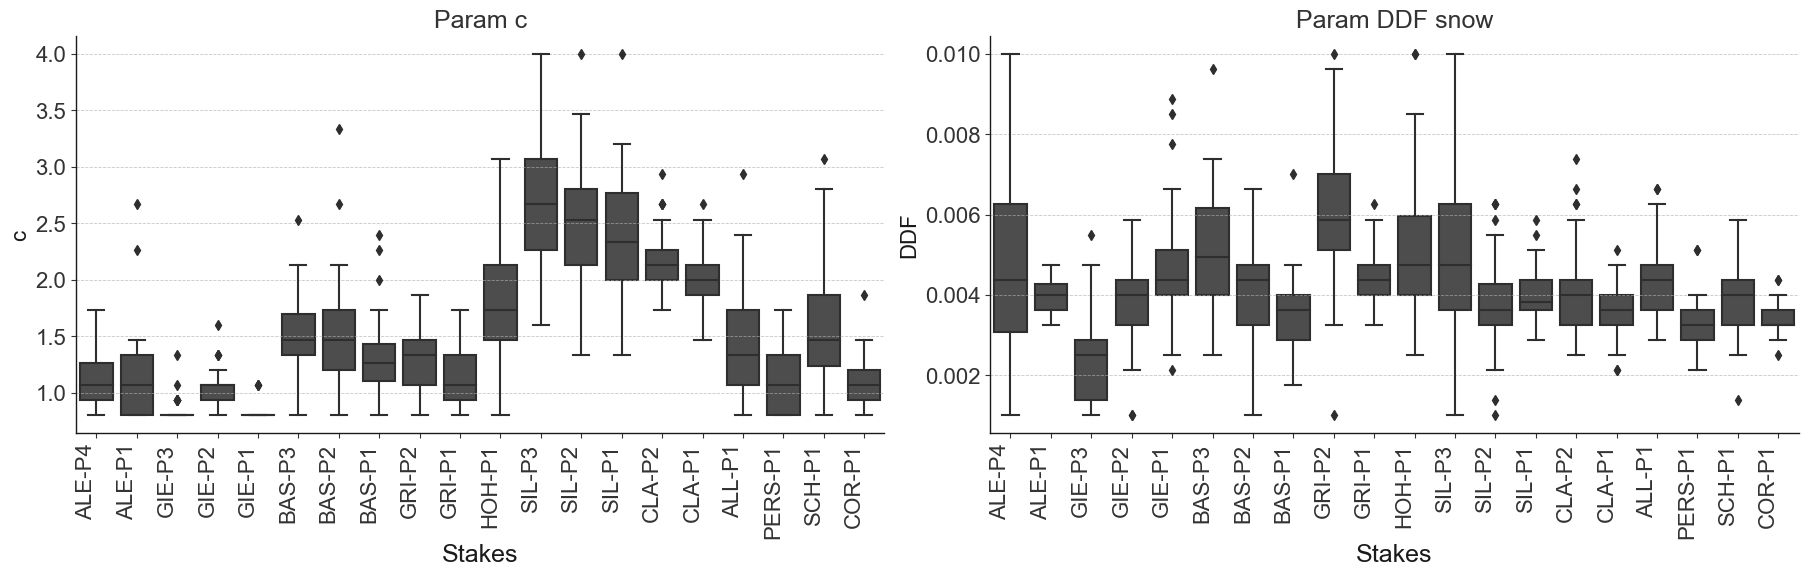

In [21]:
# read pkl files:
with open(path_extreme + f"c_2022_2023.pkl", "rb") as fp:
    c_stake = pickle.load(fp)
with open(path_extreme + f"DDF_2022_2023.pkl", "rb") as fp:
    DDF_stake = pickle.load(fp)

param_df = pd.DataFrame(np.concatenate(list(c_stake.values())), columns=['c'])
stakes = []
for key in c_stake.keys():
    stakes.append(np.tile(key, len(c_stake[key])))
param_df['stake'] = np.concatenate(stakes)
param_df['stake'] = param_df['stake'].apply(lambda x: rename_stakes[x])
param_df['DDF'] = np.concatenate(list(DDF_stake.values()))
param_df['glacier'] = param_df.stake.apply(lambda x: x.split('-')[0])
param_df['stakes_full'] = param_df.glacier.apply(lambda x: GL_SHORT[
    x]) + '-' + param_df.stake.apply(lambda x: x.split('-')[1])

fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(2, 2, 1)
sns.boxplot(param_df, x='stakes_full', y='c', ax=ax, color=color_diff_xgbplus)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=90,
                   horizontalalignment='right')
ax.set_title('Param c', fontsize=18)

ax = plt.subplot(2, 2, 2)
sns.boxplot(param_df,
            x='stakes_full',
            y='DDF',
            ax=ax,
            color=color_diff_xgbplus)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=90,
                   horizontalalignment='right')
ax.set_title('Param DDF snow', fontsize=18)

for ax in fig.get_axes():
    ax.set_xlabel('Stakes', fontsize=18)

plt.tight_layout()

#### Difference to TIM:

In [22]:
stakes_extrm_2022 = [
    'ALE-P4', 'ALL-P1', 'BAS-P1', 'BAS-P2', 'BAS-P3', 'CLA-P1', 'CLA-P2',
    'COR-P1', 'GIE-P1', 'GIE-P2', 'GIE-P3', 'GRI-P1', 'GRI-P2', 'HOH-P1',
    'SCH-P1', 'SIL-P2', 'SIL-P3'
]

stakes_extrm_2023 = [
    'ALL-P1',
    'BAS-P1',
    'BAS-P3',
    'CLA-P1',
    'COR-P1',
    'GRI-P1',
    'GRI-P2',
    'HOH-P1',
    'PERS-P1',
    'SCH-P1',
]

In [23]:
def addExtrm(df, stakes_extrm_2022, stakes_extrm_2023):
    is_extrm_2022, is_extrm_2023 = [], []
    for stake in df.stakes_full:
        is_extrm_2022.append(stake in stakes_extrm_2022)
        is_extrm_2023.append(stake in stakes_extrm_2023)
    df['is_extrm_2022'] = is_extrm_2022
    df['is_extrm_2023'] = is_extrm_2023
    return df

In [24]:
# Read all csv:
# 2022 and 2023:
dfMetrics_pdd_2022_2023 = pd.read_csv(path_extreme +
                                      'metrics_pdd_2022_2023.csv')
dfMetrics_xgb_2022_2023 = pd.read_csv(path_extreme +
                                      f'metrics_2022_2023_t2m_tp.csv')
dfDiffMetrics_2022_2023 = CreateDiffMetrics_xtr(dfMetrics_xgb_2022_2023,
                                                dfMetrics_pdd_2022_2023)
dfDiffMetrics_2022_2023 = addExtrm(dfDiffMetrics_2022_2023, stakes_extrm_2022,
                                   stakes_extrm_2023)
dfDiffMetrics_2022_2023['training'] = '2021'
dfDiffMetrics_2022_2023.sort_values(by='stakes_full', inplace=True)

# Only 2023:
dfMetrics_xgb_2023 = pd.read_csv(path_extreme + f'metrics_2023_t2m_tp.csv')
dfMetrics_pdd_2023 = pd.read_csv(path_extreme + 'metrics_pdd_2023.csv')
dfDiffMetrics_2023 = pd.merge(dfMetrics_xgb_2023.drop(['Unnamed: 0'], axis=1),
                              dfMetrics_pdd_2023.drop(['Unnamed: 0'], axis=1),
                              on='stake',
                              suffixes=('_xgb', '_pdd'))
dfDiffMetrics_2023['diff_mae_2023'] = dfDiffMetrics_2023[
    'MAE_xgb'] - dfDiffMetrics_2023['MAE_pdd']
dfDiffMetrics_2023['diff_mae_2023_wrt_to_std'] = dfDiffMetrics_2023[
    'diff_mae_2023'] / np.abs(dfDiffMetrics_2023['std_obs'])
dfDiffMetrics_2023['stakes_full'] = dfDiffMetrics_2023.stake.apply(
    lambda x: GL_SHORT[x.split('-')[
        0]]) + '-' + dfDiffMetrics_2023.stake.apply(lambda x: x.split('-')[1])
dfDiffMetrics_2023 = addExtrm(dfDiffMetrics_2023, stakes_extrm_2022,
                              stakes_extrm_2023)
dfDiffMetrics_2023['training'] = '2022'
dfDiffMetrics_2023.sort_values(by='stakes_full', inplace=True)

dfDiffMetrics_all = pd.concat([dfDiffMetrics_2022_2023, dfDiffMetrics_2023],
                              axis=0).sort_values(by='stakes_full')[[
                                  'stakes_full', 'diff_mae_2023',
                                  'diff_mae_2023_wrt_to_std',
                                  'is_extrm_2023','training','std_obs'
                              ]]
dfDiffMetrics_all.head(2)

,stakes_full,diff_mae_2023,diff_mae_2023_wrt_to_std,is_extrm_2023,training,std_obs
1,ALE-P1,-1.247391,-1.276095,False,2021,0.977507
1,ALE-P1,-1.253393,-1.268309,False,2022,0.988240


In [25]:
dfDiffMetrics_all[dfDiffMetrics_all.stakes_full == 'SCH-P1']

,stakes_full,diff_mae_2023,diff_mae_2023_wrt_to_std,is_extrm_2023,training,std_obs
18,SCH-P1,0.759232,0.644560,True,2022,1.177907
18,SCH-P1,1.995278,1.840747,True,2021,1.083951


#### Fig 9: Prediction of extreme years

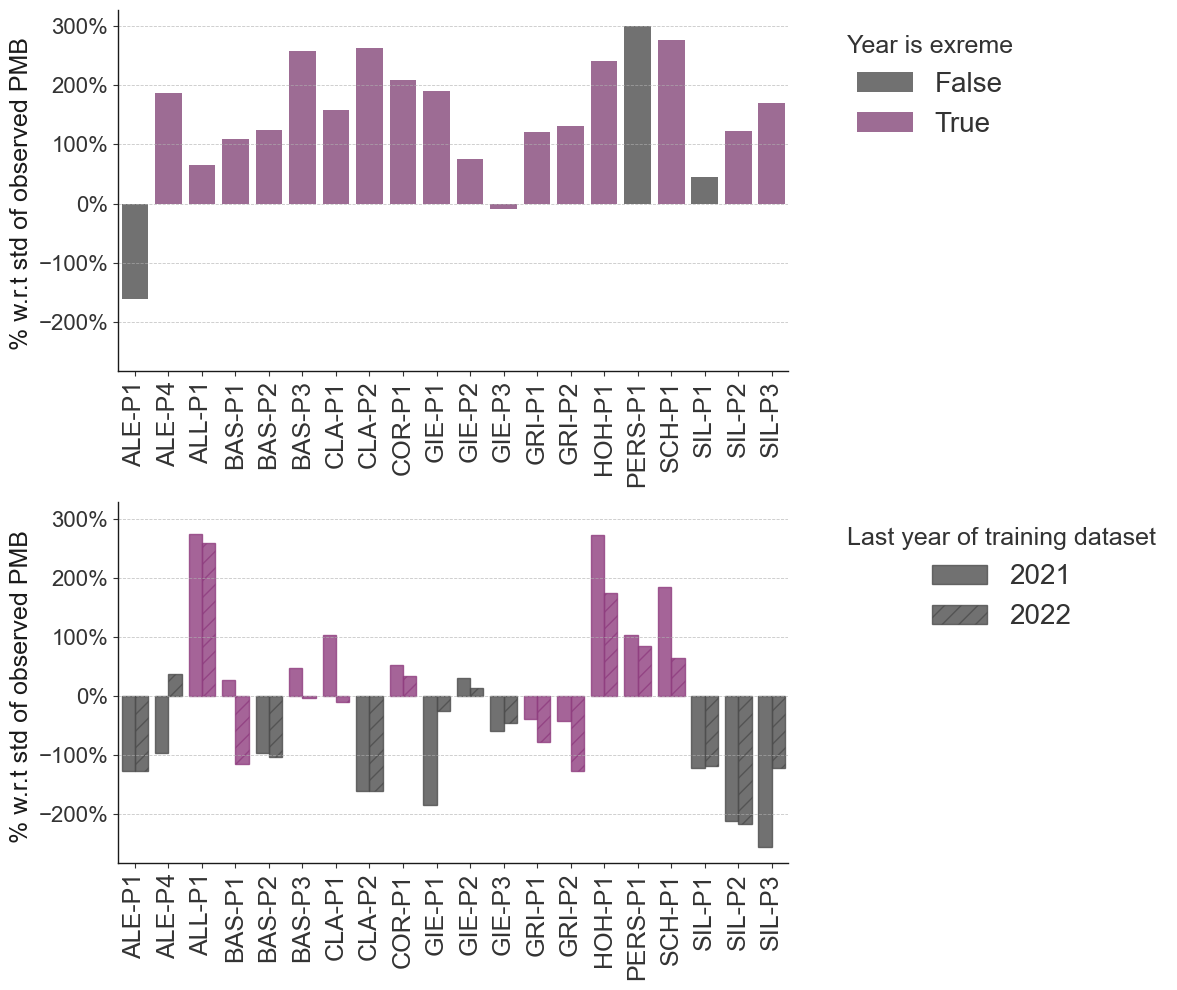

In [26]:
palette_extremes = sns.color_palette([color_diff_xgbplus, '#8f3d7f'])
alpha = 0.8
fontsize_title = 22
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharey=True)

# Diff MAE:
g = sns.barplot(
    dfDiffMetrics_2022_2023,
    x='stakes_full',
    #y=f'diff_mae_2022',
    y = 'diff_mae_2022_wrt_to_std',
    ax=ax1,
    dodge=False,
    hue='is_extrm_2022',
    palette=palette_extremes,
    alpha=alpha,
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Diff MAE:
g = sns.barplot(
    dfDiffMetrics_all,
    x='stakes_full',
    #y=f'diff_mae_2023',
    y = 'diff_mae_2023_wrt_to_std',
    ax=ax2,
    hue='training',
    palette=palette_extremes,
    alpha=alpha,
)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
num_locations = len(dfDiffMetrics_all.stakes_full.unique())
# hatches = itertools.cycle(['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.'])
hatch = '//'
for i, bar in enumerate(ax2.patches):
    value = bar.get_height()
    training = dfDiffMetrics_all.iloc[(
        dfDiffMetrics_all['diff_mae_2023_wrt_to_std'] -
        value).abs().argsort()[:1]].training.values[0]
    if training == '2022':
        bar.set_hatch(hatch)
    # find location in dataframe:
    isextrm = dfDiffMetrics_all.iloc[(
        dfDiffMetrics_all['diff_mae_2023_wrt_to_std'] -
        value).abs().argsort()[:1]].is_extrm_2023.values
    if isextrm:
        bar.set_color(palette_extremes[1])
    else:
        bar.set_color(palette_extremes[0])

for ax in [ax1, ax2]:
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f'')
    #ax.set_ylabel('[m w.e.]', fontsize=18)
    ax.set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2.legend(title='Last year of training dataset',
           fontsize="20",
           bbox_to_anchor=(1.05, 1),
           loc=2,
           ncol=1,
           fancybox=True,
           shadow=False,
           frameon=False)
ax1.legend(title='Year is exreme',
           fontsize="20",
           bbox_to_anchor=(1.05, 1),
           loc=2,
           ncol=1,
           fancybox=True,
           shadow=False,
           frameon=False)
plt.tight_layout()

In [27]:
dfDiffMetrics_all[dfDiffMetrics_all.stakes_full == 'BAS-P3']

,stakes_full,diff_mae_2023,diff_mae_2023_wrt_to_std,is_extrm_2023,training,std_obs
5,BAS-P3,-0.037189,-0.035223,True,2022,1.055806
5,BAS-P3,0.402790,0.476402,True,2021,0.845483


#### Fig A2: all stakes without param range

/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["years"] = target_years
/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["years"] = target_years
/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

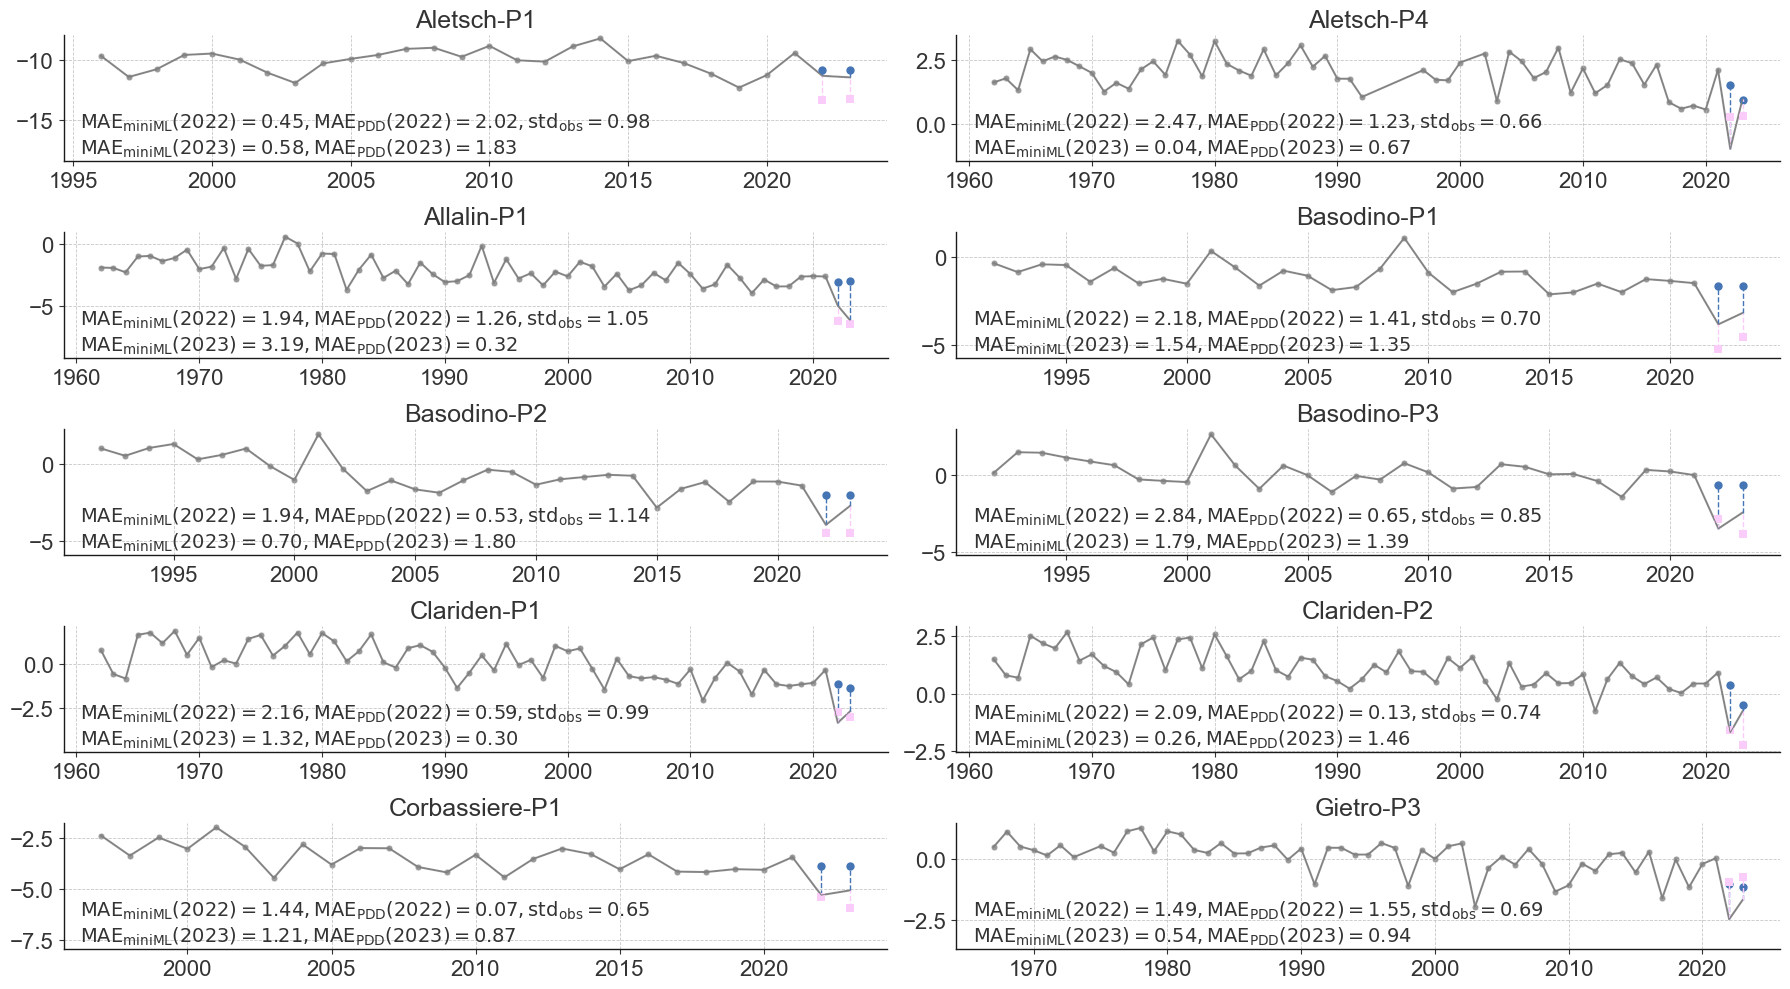

In [28]:
VARS = ['t2m', 'tp']
dfMetrics_xgb = pd.read_csv(path_extreme +
                            f'metrics_2022_2023_{VARS[0]}_{VARS[1]}.csv')
dfPred_xgb_2022_2023 = pd.read_csv(path_extreme +
                         f'predictions_2022_2023_{VARS[0]}_{VARS[1]}.csv')
dfPred_xgb_2022_2023.rename(columns={'2023': 2023, '2022': 2022}, inplace=True)

stakesExtreme.sort()
fig = plt.figure(figsize=(18, 10))
M, N = 5, 2
for i, stake_old in enumerate(stakesExtreme[:10]):
    ax = plt.subplot(M, N, i + 1)
    stake_new = rename_stakes[stake_old]
    plotPredStake(stake_new, stake_old, weights_t2m, weights_tp,
                  dfMetrics_pdd_2022_2023, dfMetrics_xgb_2022_2023,
                  dfPred_pdd_2022_2023, dfPred_xgb_2022_2023, best_combi, ax,
                  INPUT_TYPE, color_xgb, color_tim, marker_xgb, marker_tim,
                  VARS)

    ax.set_xlabel('')
    # ax.set_ylabel('[m w.e.]')
    ax.set_ylabel('')
    ax.legend([], [], frameon=False)
    ax.set_title(stake_new)

plt.tight_layout()

/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["years"] = target_years
/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["years"] = target_years
/scratch-3/vmarijn/miniML-MB/src/scripts/xgb_extreme.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

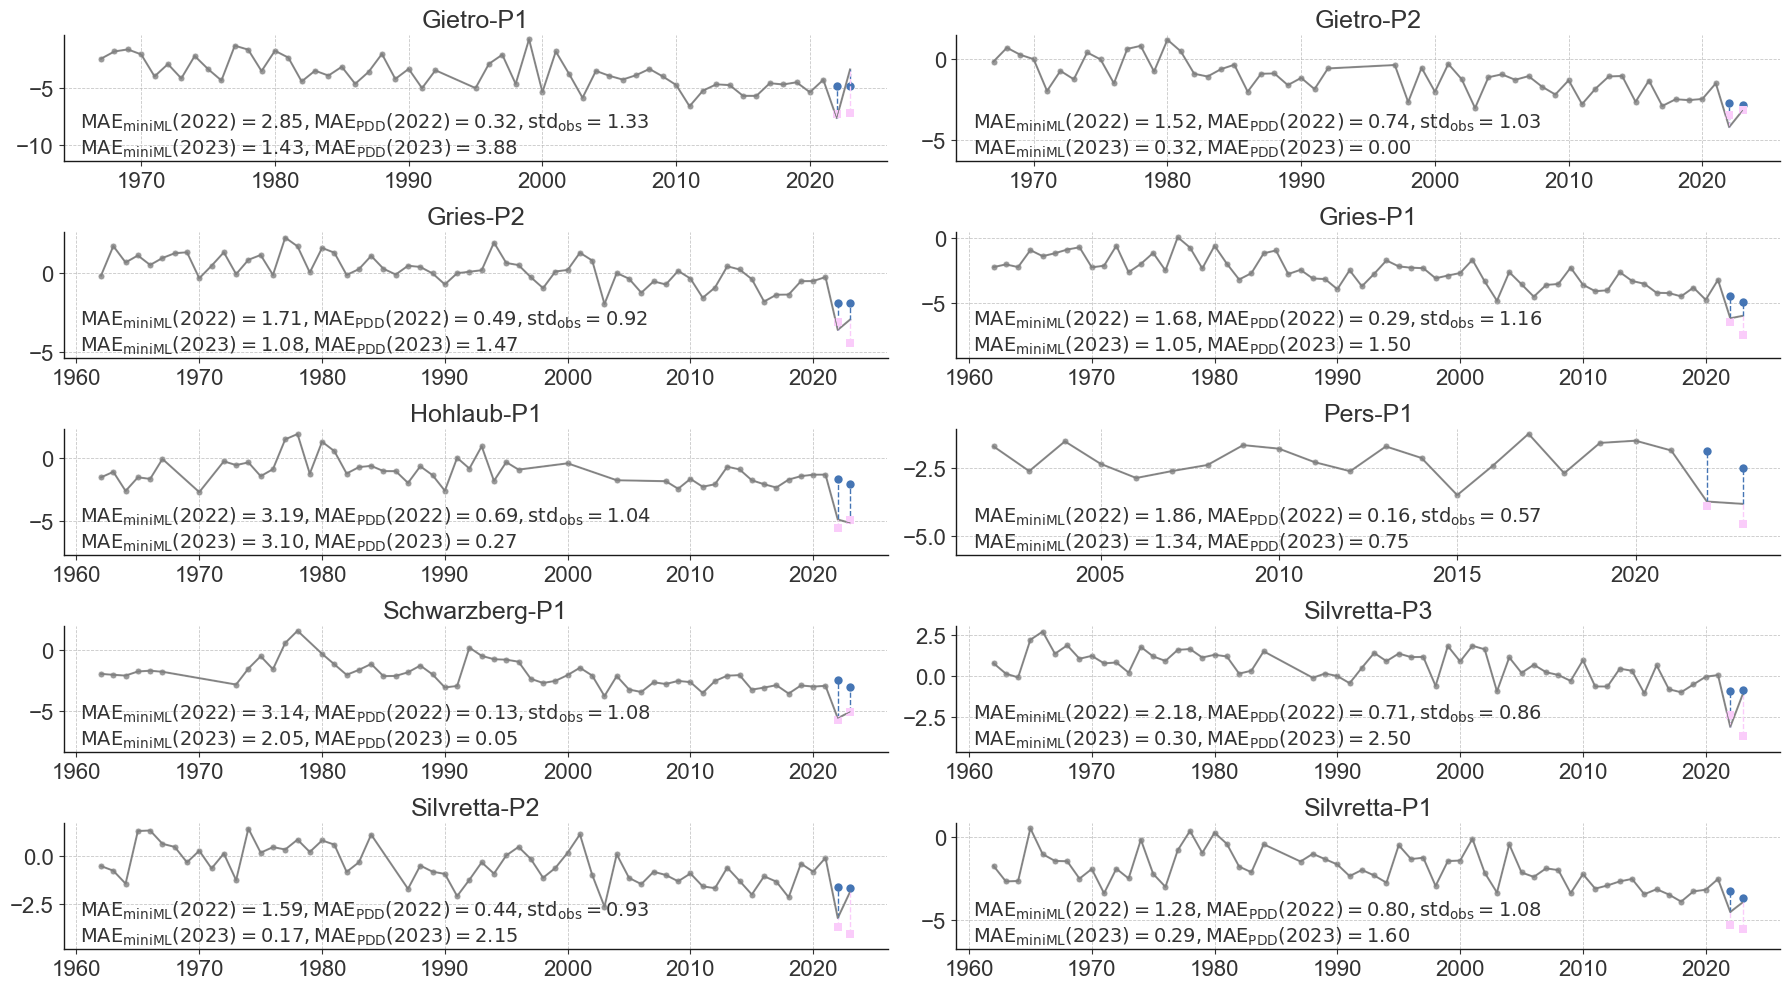

In [29]:
fig = plt.figure(figsize=(18, 10))
M, N = 5, 2
for i, stake_old in enumerate(stakesExtreme[10:]):
    ax = plt.subplot(M, N, i + 1)
    stake_new = rename_stakes[stake_old]
    plotPredStake(stake_new, stake_old, weights_t2m, weights_tp,
                  dfMetrics_pdd_2022_2023, dfMetrics_xgb_2022_2023,
                  dfPred_pdd_2022_2023, dfPred_xgb_2022_2023, best_combi, ax,
                  INPUT_TYPE, color_xgb, color_tim, marker_xgb, marker_tim,
                  VARS)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend([], [], frameon=False)
    ax.set_title(stake_new)

plt.tight_layout()

### Tested on 2023:

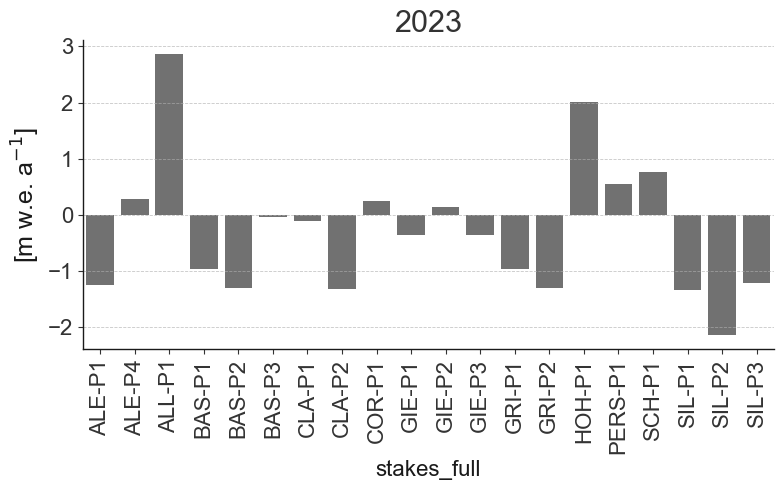

In [30]:
possible_var = [['t2m', 'tp']]
fig = plt.figure(figsize=(15, 5))
M, N = 1, 2
alpha = 0.8
fontsize_title = 22

for i, VARS in enumerate(possible_var):
    vars_ = f'climate variables {VARS[0]} & {VARS[1]}'
    dfMetrics_xgb = pd.read_csv(path_extreme +
                                f'metrics_2023_{VARS[0]}_{VARS[1]}.csv')
    dfPred_xgb = pd.read_csv(path_extreme +
                             f'predictions_2023_{VARS[0]}_{VARS[1]}.csv')
    dfPred_xgb.rename(columns={'2023': 2023}, inplace=True)

    dfDiffMetrics_2023 = pd.merge(dfMetrics_xgb.drop(['Unnamed: 0'], axis=1),
                                  dfMetrics_pdd_2023.drop(['Unnamed: 0'],
                                                          axis=1),
                                  on='stake',
                                  suffixes=('_xgb', '_pdd'))
    dfDiffMetrics_2023['diff_mae'] = dfDiffMetrics_2023[
        'MAE_xgb'] - dfDiffMetrics_2023['MAE_pdd']

    dfDiffMetrics_2023['stakes_full'] = dfDiffMetrics_2023.stake.apply(
        lambda x: GL_SHORT[x.split('-')[0]]
    ) + '-' + dfDiffMetrics_2023.stake.apply(lambda x: x.split('-')[1])

    dfDiffMetrics_2023.sort_values(by='stakes_full', inplace=True)

    # Diff MAE both:
    ax1 = plt.subplot(M, N, i + 1)
    g = sns.barplot(
        dfDiffMetrics_2023,
        x='stakes_full',
        y=f'diff_mae',
        ax=ax1,
        dodge=False,
        color=color_diff_xgbplus,
        alpha=alpha,
    )
    h, l = g.get_legend_handles_labels()
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.set_ylabel('[m w.e. a$^{-1}$]', fontsize=18)
    ax1.set_title(f'2023', fontsize=fontsize_title)
plt.tight_layout()

/tmp/ipykernel_2837311/3705038996.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
/tmp/ipykernel_2837311/3705038996.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)


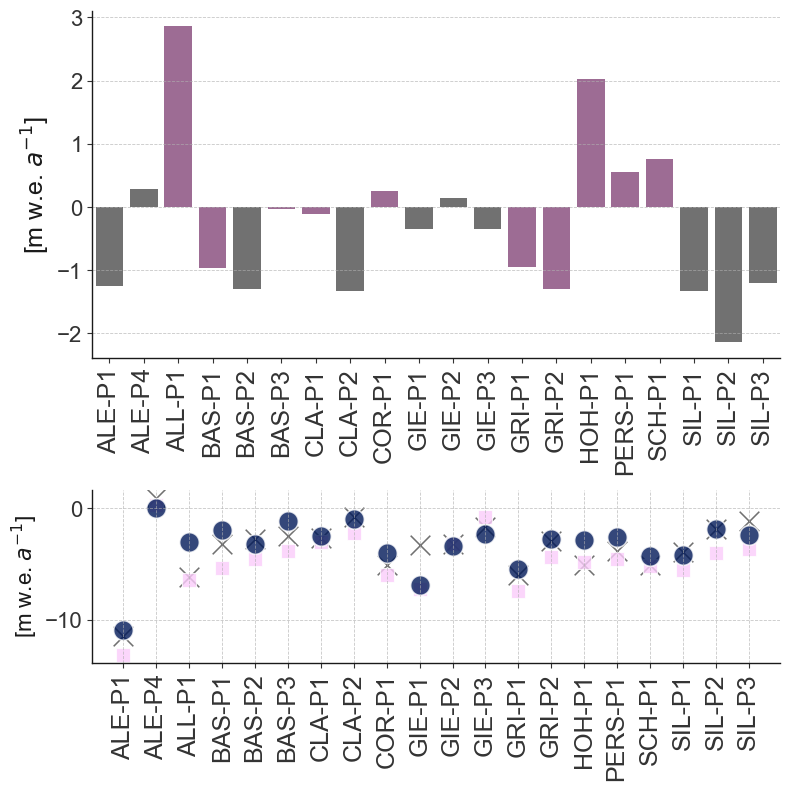

In [31]:
possible_var = ['t2m', 'tp']
palette_extremes = sns.color_palette([color_diff_xgbplus, '#8f3d7f'])

dfMetrics_xgb_2023 = pd.read_csv(
    path_extreme + f'metrics_2023_{possible_var[0]}_{possible_var[1]}.csv')
dfMetrics_pdd_2023 = pd.read_csv(path_extreme + 'metrics_pdd_2023.csv')

dfDiffMetrics_2023 = pd.merge(dfMetrics_xgb_2023.drop(['Unnamed: 0'], axis=1),
                              dfMetrics_pdd_2023.drop(['Unnamed: 0'], axis=1),
                              on='stake',
                              suffixes=('_xgb', '_pdd'))
dfDiffMetrics_2023['diff_mae_2023'] = dfDiffMetrics_2023[
    'MAE_xgb'] - dfDiffMetrics_2023['MAE_pdd']

dfDiffMetrics_2023['stakes_full'] = dfDiffMetrics_2023.stake.apply(
    lambda x: GL_SHORT[x.split('-')[
        0]]) + '-' + dfDiffMetrics_2023.stake.apply(lambda x: x.split('-')[1])

is_extrm_2023 = []
for stake in dfDiffMetrics_2023.stakes_full:
    is_extrm_2023.append(stake in stakes_extrm_2023)
dfDiffMetrics_2023['is_extrm_2023'] = is_extrm_2023
dfDiffMetrics_2023.sort_values(by='stakes_full', inplace=True)

dfPred_xgb = pd.read_csv(
    path_extreme + f'predictions_2023_{possible_var[0]}_{possible_var[1]}.csv')
dfPred_xgb['stakes_full'] = dfPred_xgb.stake.apply(lambda x: GL_SHORT[x.split(
    '-')[0]]) + '-' + dfPred_xgb.stake.apply(lambda x: x.split('-')[1])

dfPred_pdd = pd.read_csv(path_extreme + f'predictions_pdd_2023.csv')
dfPred_pdd['stakes_full'] = dfPred_pdd.stake.apply(lambda x: GL_SHORT[x.split(
    '-')[0]]) + '-' + dfPred_pdd.stake.apply(lambda x: x.split('-')[1])
is_extrm_2023 = []
for stake in dfPred_xgb.stakes_full:
    is_extrm_2023.append(stake in stakes_extrm_2023)
dfPred_xgb['is_extrm_2023'] = is_extrm_2023

# change from mm to m
dfPred_pdd['2023'] = dfPred_pdd['2023'] / 1000
dfPred_xgb['2023_target'] = dfPred_xgb['2023_target'] / 1000
dfPred_xgb['2023'] = dfPred_xgb['2023'] / 1000
dfPred_xgb.sort_values(by='stakes_full', inplace=True)

alpha = 0.8
fontsize_title = 22
f, (ax1, ax2) = plt.subplots(2,
                             1,
                             figsize=(8, 8),
                             gridspec_kw={"height_ratios": [1, 0.5]})

# Diff MAE:
# ax1 = plt.subplot(M, N, pos)
g = sns.barplot(
    dfDiffMetrics_2023,
    x='stakes_full',
    y=f'diff_mae_2023',
    ax=ax1,
    dodge=False,
    # color=color_diff_xgbplus,
    hue='is_extrm_2023',
    palette=palette_extremes,
    alpha=alpha,
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Target 2023:
sns.scatterplot(dfPred_xgb,
                x='stakes_full',
                y=f'2023_target',
                ax=ax2,
                color=color_diff_xgbplus,
                alpha=alpha,
                s=200,
                marker='x')
sns.scatterplot(dfPred_pdd,
                x='stakes_full',
                y=f'2023',
                ax=ax2,
                alpha=alpha,
                marker=marker_tim,
                color=color_tim)
g = sns.scatterplot(dfPred_xgb,
                    x='stakes_full',
                    y='2023',
                    ax=ax2,
                    alpha=alpha,
                    color=color_xgbplus,
                    marker=marker_xgb,
                    s=200)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title(f'', fontsize=fontsize_title)

for ax in [ax1, ax2]:
    ax.legend([], [], frameon=False)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.set_title(f'')

ax1.set_ylabel('[m w.e. $a^{-1}$]', fontsize=18)
ax2.set_ylabel('[m w.e. $a^{-1}$]')
plt.tight_layout()

### Tested on 2022:

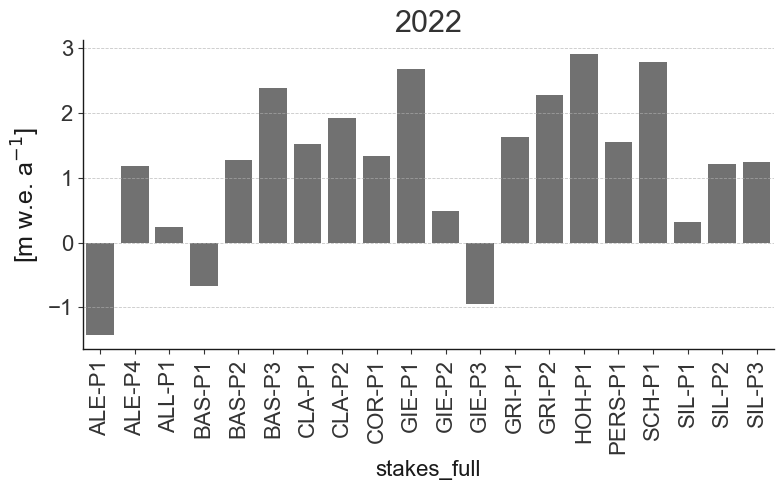

In [32]:
possible_var = [['t2m', 'tp']]

fig = plt.figure(figsize=(15, 5))
M, N = 1, 2
alpha = 0.8
fontsize_title = 22

for i, VARS in enumerate(possible_var):
    vars_ = f'climate variables {VARS[0]} & {VARS[1]}'
    dfMetrics_xgb = pd.read_csv(path_extreme +
                                f'metrics_2022_{VARS[0]}_{VARS[1]}.csv')
    dfPred_xgb = pd.read_csv(path_extreme +
                             f'predictions_2022_{VARS[0]}_{VARS[1]}.csv')
    dfPred_xgb.rename(columns={'2022': 2022}, inplace=True)

    dfDiffMetrics_2022 = pd.merge(dfMetrics_xgb.drop(['Unnamed: 0'], axis=1),
                                  dfMetrics_pdd_2022.drop(['Unnamed: 0'],
                                                          axis=1),
                                  on='stake',
                                  suffixes=('_xgb', '_pdd'))
    dfDiffMetrics_2022['diff_mae'] = dfDiffMetrics_2022[
        'MAE_xgb'] - dfDiffMetrics_2022['MAE_pdd']

    dfDiffMetrics_2022['stakes_full'] = dfDiffMetrics_2022.stake.apply(
        lambda x: GL_SHORT[x.split('-')[0]]
    ) + '-' + dfDiffMetrics_2022.stake.apply(lambda x: x.split('-')[1])
    dfDiffMetrics_2022.sort_values(by='stakes_full', inplace=True)

    # Diff MAE both:
    ax1 = plt.subplot(M, N, i + 1)
    g = sns.barplot(
        dfDiffMetrics_2022,
        x='stakes_full',
        y=f'diff_mae',
        ax=ax1,
        dodge=False,
        color=color_diff_xgbplus,
        alpha=alpha,
    )
    h, l = g.get_legend_handles_labels()
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.set_ylabel('[m w.e. a$^{-1}$]', fontsize=18)
    ax1.set_title(f'2022', fontsize=fontsize_title)
plt.tight_layout()